In [1]:
%matplotlib inline


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

In [3]:
target = 'l 98-59'
tpf = lightkurve.search_targetpixelfile(target).download()

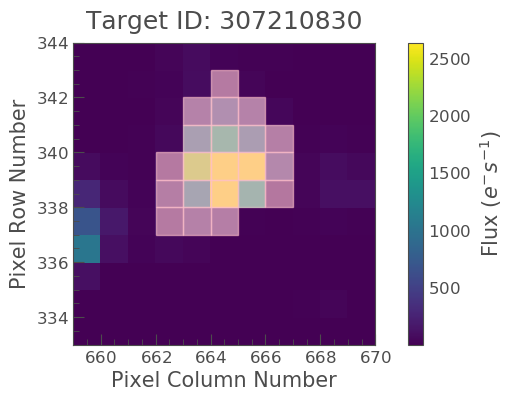

In [4]:
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (tpf.time.min() + tpf.time.max())
flux = tpf.flux

pix_mask = tpf.create_threshold_mask(threshold=3)
tpf.plot(aperture_mask=pix_mask, )


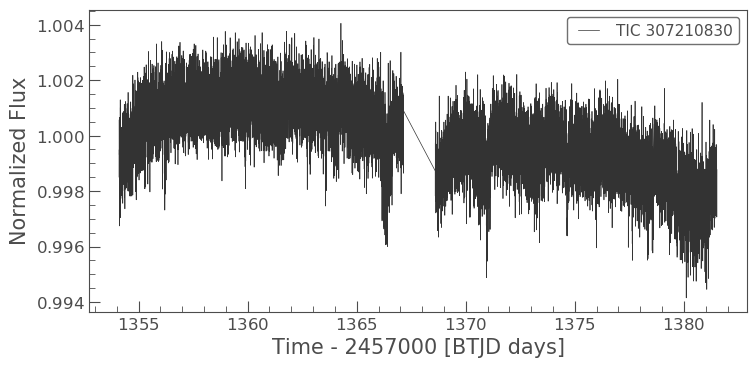

In [5]:
lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
lc = lc.normalize()
lc.plot()
lc.flux = (lc.flux - 1.0) * 1e3

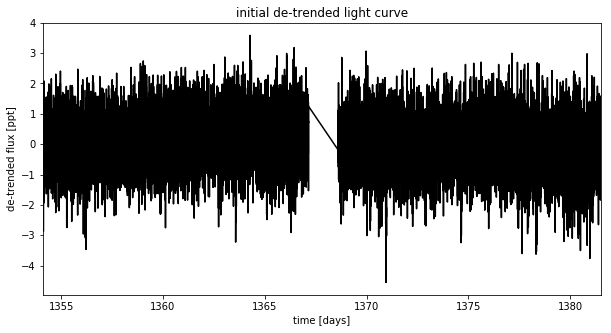

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [7]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
duration = 0.03

bls_periods = np.zeros([3])
bls_t0s = np.zeros([3])
bls_depths = np.zeros([3])
time = lc.time - ref_time

# planet 1
bls = BoxLeastSquares(time, lc.flux - pld_flux)
bls_power = bls.power(period_grid, duration, oversample=20)

bls_power0 = bls_power

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

bls_periods[0] = bls_period
bls_t0s[0] = bls_t0
bls_depths[0] = bls_depth

# planet 2
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[1] = bls_period
bls_t0s[1] = bls_t0
bls_depths[1] = bls_depth

# planet 3
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[2] = bls_period
bls_t0s[2] = bls_t0
bls_depths[2] = bls_depth

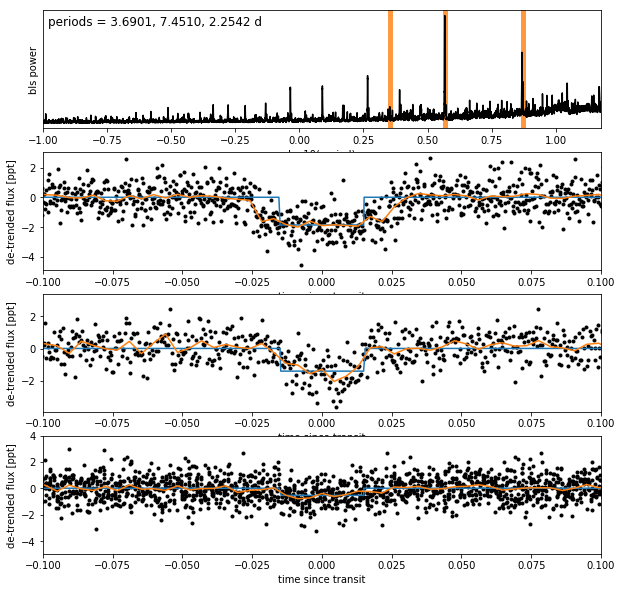

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f} d".format(*bls_periods),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transits
bls = BoxLeastSquares(time, lc.flux - pld_flux)
for i in range(3):
    ax = axes[i+1]
    x_fold = (time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], lc.flux[m] - pld_flux[m], ".k")
    inds = np.argsort(x_fold[m])
    ax.plot(x_fold[m][inds], bls.model(time, bls_periods[i], duration, bls_t0s[i])[m][inds])

    # Overplot the phase binned light curve
    bins = np.linspace(-0.11, 0.11, 52)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=lc.flux - pld_flux)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.1, 0.1)
    ax.set_ylabel("de-trended flux [ppt]")
    ax.set_xlabel("time since transit");

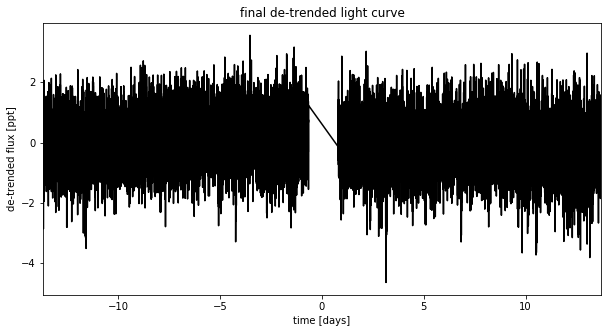

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(lc.time-ref_time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(x.min(), x.max());

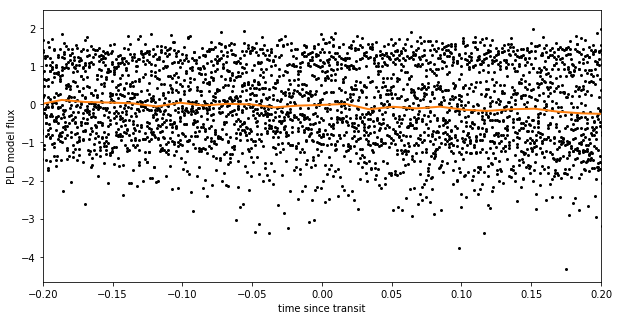

In [10]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

In [52]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        
        # Stellar parameters from Kostov et al (2018)
        R_star_kostov = 0.291, 0.025
#         M_star_kostov = 0.32, 0.025
        Rho_star_kostov = 18.0, 2.0
#         m_star = pm.Normal("m_star", mu=M_star_kostov[0], sd=M_star_kostov[1])
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])

        rho_star = pm.Normal("rho_star", mu=Rho_star_kostov[0], sd=Rho_star_kostov[1])

        # Prior to require physical parameters
#         pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=1, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=1, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=1, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.01, max_radius=0.3,
#             testval_r=np.sqrt(1e-3)*np.sqrt(bls_depths),
#             testval_b=[0.1,0.8,0.1])
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.01, shape=3)
        omega = xo.distributions.Angle("omega", shape=3)
        
        # Log-uniform prior on ror
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))
#         pm.Potential("ror_prior", -tt.log(ror))

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logS0 = pm.Normal("logS0", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        
        a = pm.Deterministic("a", orbit.a)
#         pm.Potential("ecc_prior", tt.switch((ecc < 1 - (1/a)), 0, -np.inf))

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve - mean))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[logs2, logS0, logw0])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

logp = -22,743, ||grad|| = 3.3764: 100%|██████████| 27/27 [00:00<00:00, 59.67it/s]  
logp = -22,627, ||grad|| = 2.6904: 100%|██████████| 36/36 [00:00<00:00, 62.29it/s]  
logp = -22,620, ||grad|| = 7,946.4: 100%|██████████| 51/51 [00:01<00:00, 50.98it/s]  


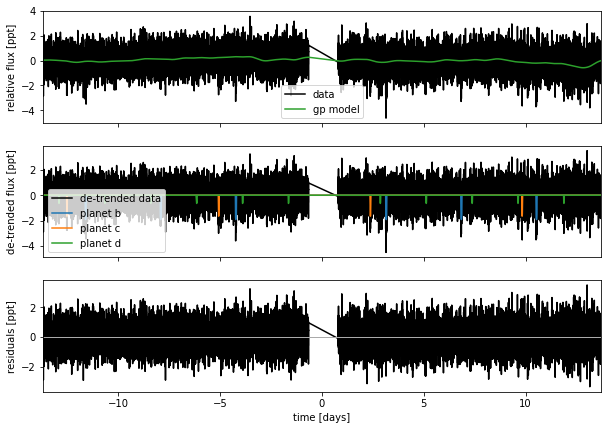

In [53]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.gp_pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

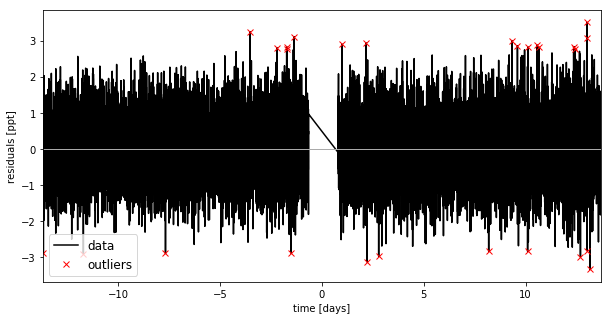

In [54]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

logp = -22,425, ||grad|| = 0.42043: 100%|██████████| 23/23 [00:00<00:00, 62.82it/s]  
logp = -22,425, ||grad|| = 0.76138: 100%|██████████| 15/15 [00:00<00:00, 70.84it/s]  
logp = -22,425, ||grad|| = 674: 100%|██████████| 15/15 [00:00<00:00, 56.67it/s]  


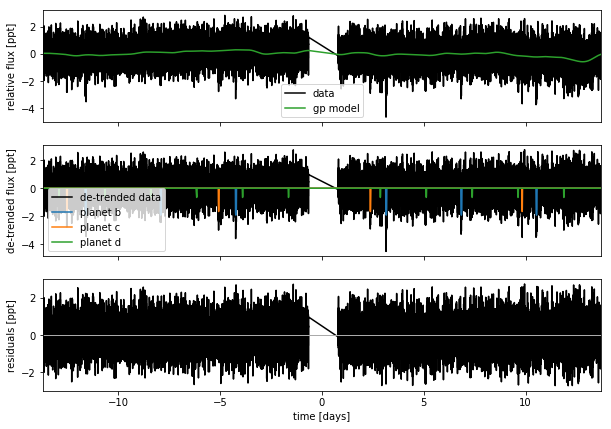

In [55]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(model, map_soln, mask);

In [56]:
sampler = xo.PyMC3Sampler(window=100, start=200, finish=200)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln, step_kwargs=dict(target_accept=0.9))

Sampling 4 chains: 100%|██████████| 8408/8408 [2:35:20<00:00,  6.65s/draws]


In [57]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logw0, logS0, logs2, omega, ecc, b_param, logror, t0, logP, rho_star, r_star, u_star, mean]
INFO:pymc3:NUTS: [logw0, logS0, logs2, omega, ecc, b_param, logror, t0, logP, rho_star, r_star, u_star, mean]
Sampling 4 chains: 100%|██████████| 8800/8800 [2:12:02<00:00,  3.28s/draws]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize

In [58]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", 
                            "ecc", "b", "r_pl", "t0", "period", "r_star", "rho_star", "u_star", "mean"])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
logw0       0.483103  0.203989  0.002603   0.089949   0.880612  5967.446238   
logS0      -3.442280  0.509334  0.007000  -4.346612  -2.437454  5305.399872   
logs2      -0.393185  0.010488  0.000107  -0.414040  -0.372992  8222.738862   
omega__0   -1.010982  1.534015  0.026625  -3.141473   2.567359  3558.286959   
omega__1    0.380635  1.743105  0.051913  -2.775444   3.132651   988.052332   
omega__2   -0.181939  1.864992  0.030863  -3.140133   2.903474  4738.892467   
ecc__0      0.159238  0.156625  0.002990   0.000001   0.495379  2440.896592   
ecc__1      0.250666  0.220569  0.012254   0.000002   0.672027   225.112062   
ecc__2      0.141382  0.143170  0.001926   0.000007   0.443309  4973.811527   
b__0        0.243182  0.159624  0.003286   0.001660   0.527994  1910.091635   
b__1        0.845595  0.184322  0.007502   0.383763   1.044032   382.563953   
b__2        0.296348  0.168494  0.003367   0.001111   0.566874  3010.072112   
r_pl__0     0.011790  0.001106  0.000015   0.009727   0.014104  5824.606377   
r_pl__1     0.012340  0.001534  0.000056   0.009312   0.015206   609.575162   
r_pl__2     0.006509  0.000674  0.000008   0.005228   0.007854  7202.736957   
t0__0      -0.535157  0.000493  0.000007  -0.536115  -0.534139  5280.169432   
t0__1      -5.073241  0.000791  0.000010  -5.074809  -5.071749  6315.744494   
t0__2      -1.640162  0.001205  0.000026  -1.642565  -1.637759  2375.598526   
period__0   3.690572  0.000205  0.000003   3.690163   3.690981  6087.858253   
period__1   7.451495  0.000546  0.000007   7.450482   7.452563  5590.523546   
period__2   2.253130  0.000308  0.000004   2.252542   2.253754  5811.574860   
r_star      0.290931  0.025129  0.000273   0.242871   0.341501  7993.883999   
rho_star   17.553628  1.840219  0.029762  14.091067  21.265054  4255.649022   
u_star__0   0.454874  0.265489  0.005181   0.000105   0.922067  2568.707862   
u_star__1   0.179904  0.333038  0.005241  -0.389471   0.818685  4488.163103   
mean        0.012367  0.051669  0.000656  -0.086913   0.118196  5302.234601   

               Rhat  
logw0      0.999944  
logS0      1.000030  
logs2      1.000326  
omega__0   1.000338  
omega__1   1.000284  
omega__2   1.000245  
ecc__0     0.999857  
ecc__1     1.000256  
ecc__2     1.000072  
b__0       0.999943  
b__1       1.000247  
b__2       0.999973  
r_pl__0    1.000309  
r_pl__1    1.000096  
r_pl__2    0.999873  
t0__0      0.999848  
t0__1      1.000148  
t0__2      1.000784  
period__0  0.999792  
period__1  0.999918  
period__2  1.000595  
r_star     0.999973  
rho_star   1.000064  
u_star__0  1.000199  
u_star__1  0.999943  
mean       1.000034

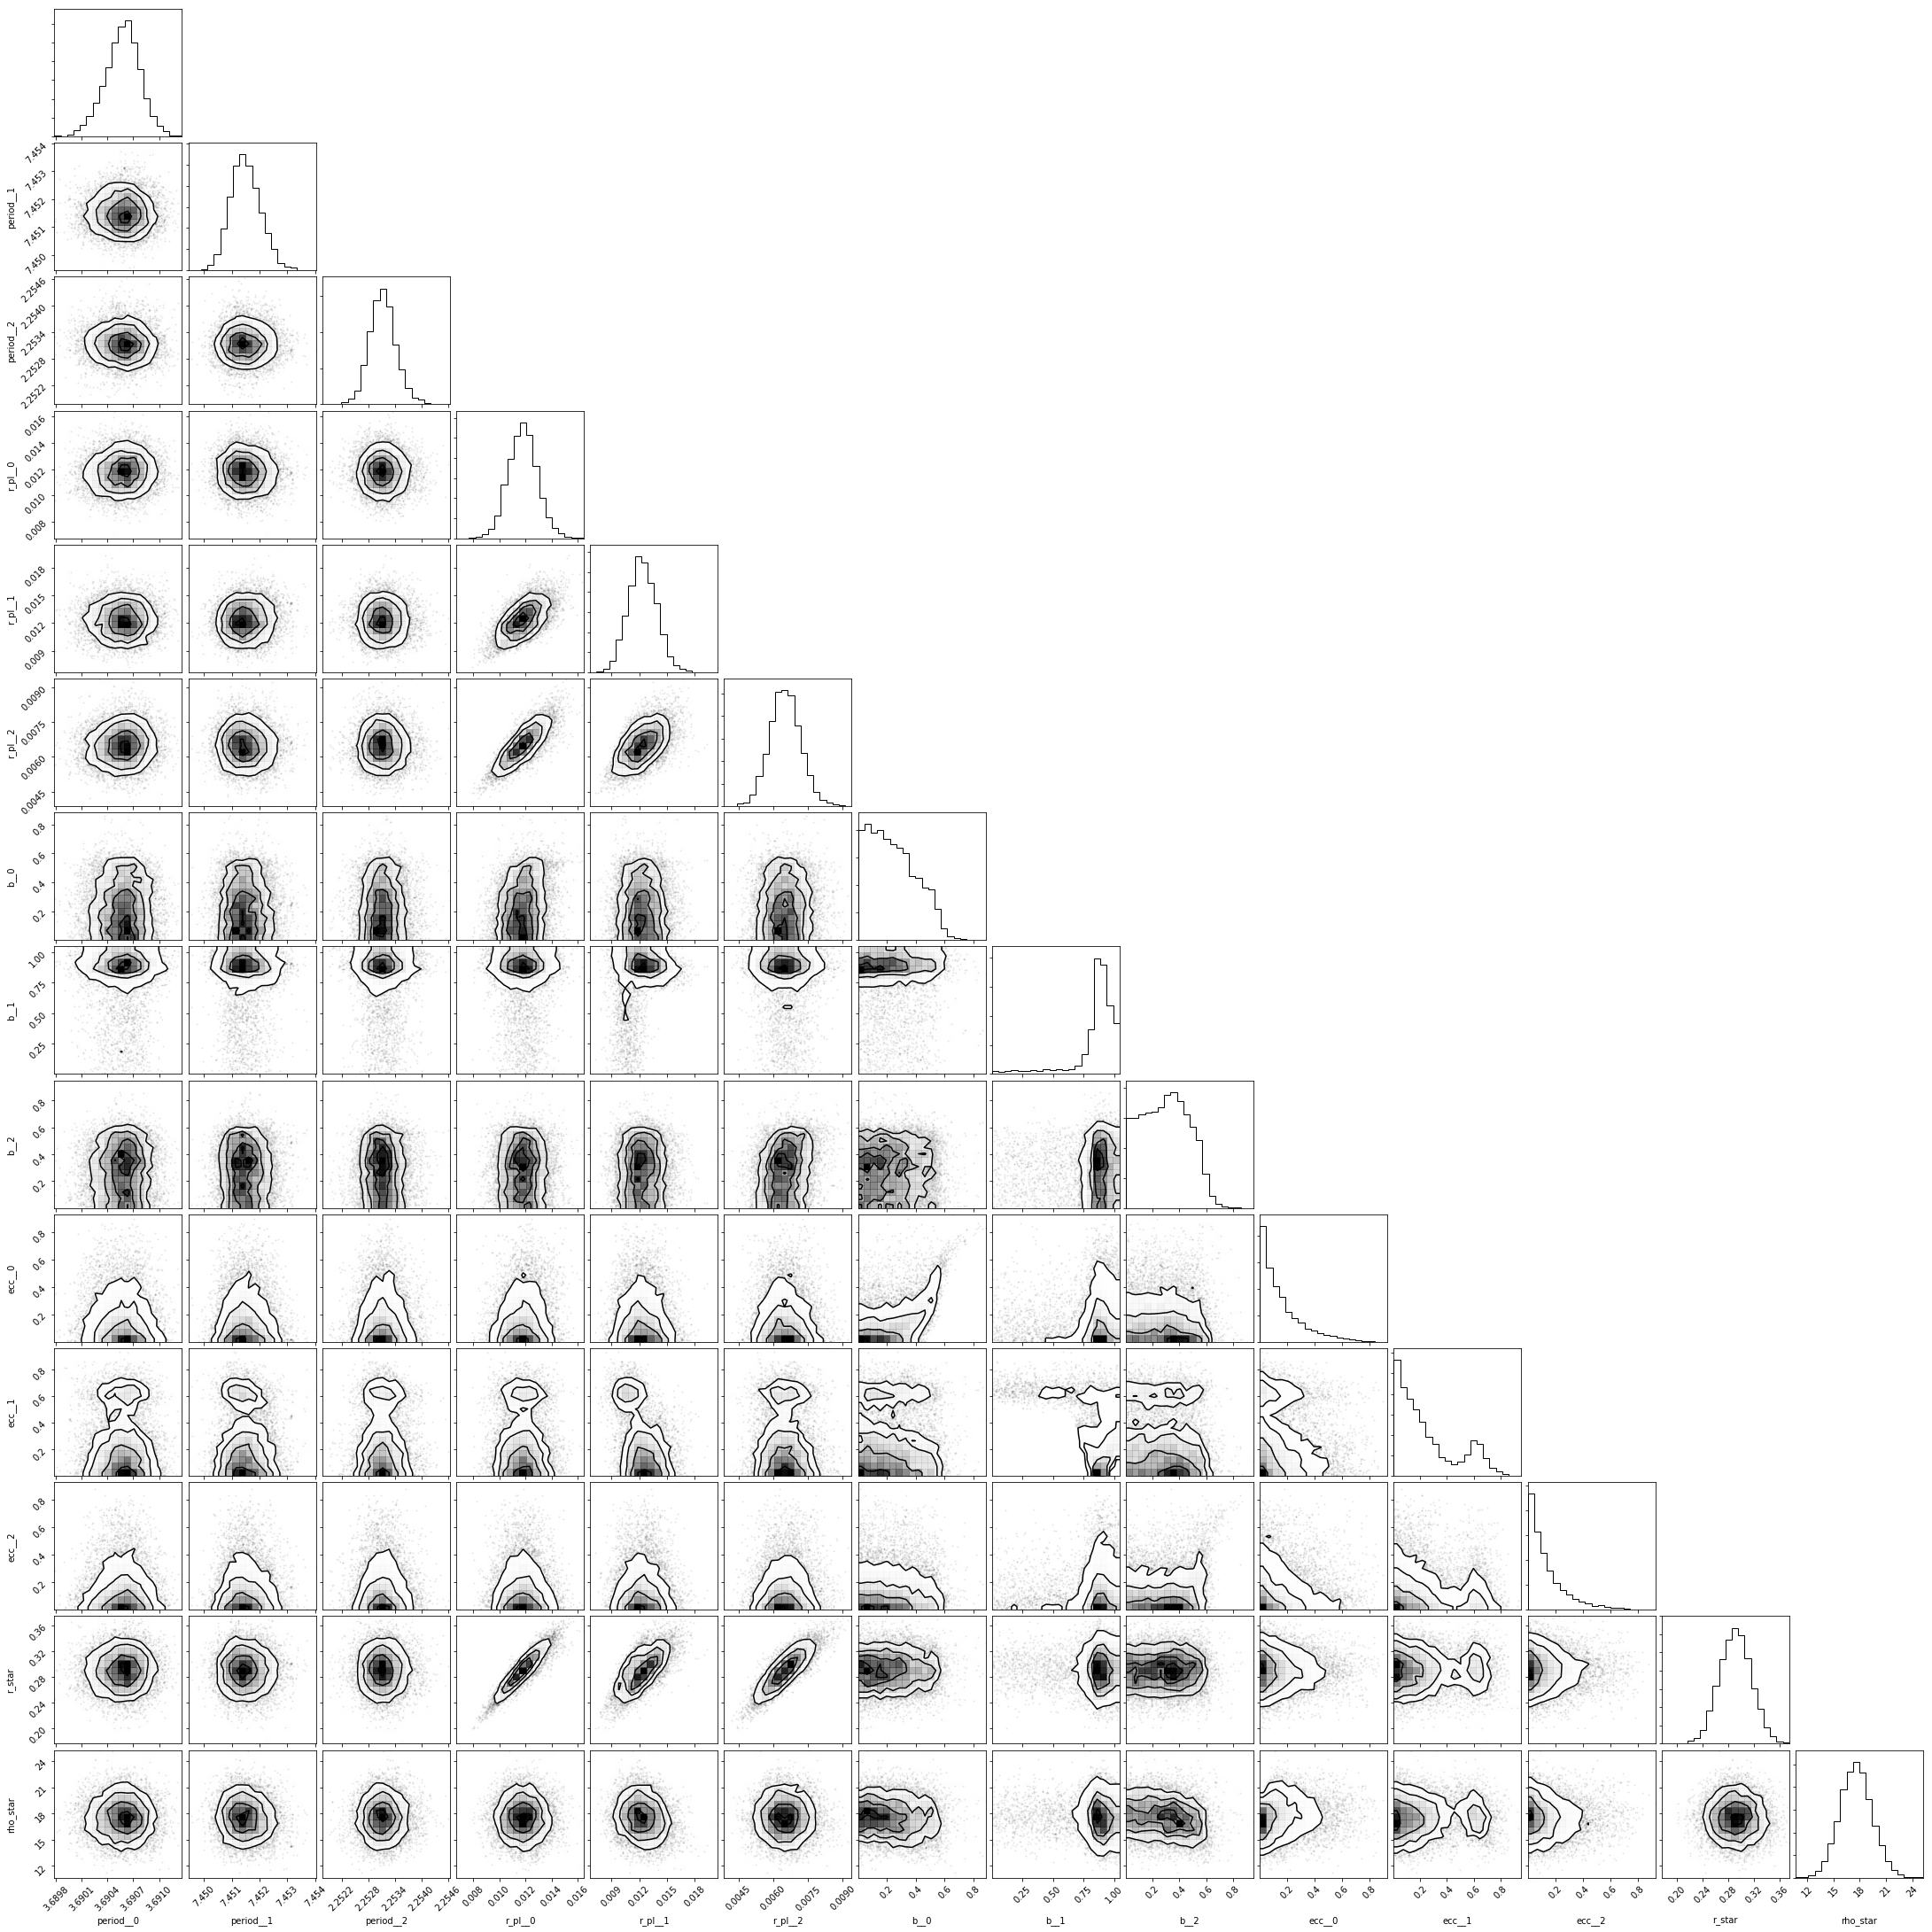

In [59]:
import corner
varnames = ["period", "r_pl", "b", "ecc", "r_star", "rho_star"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

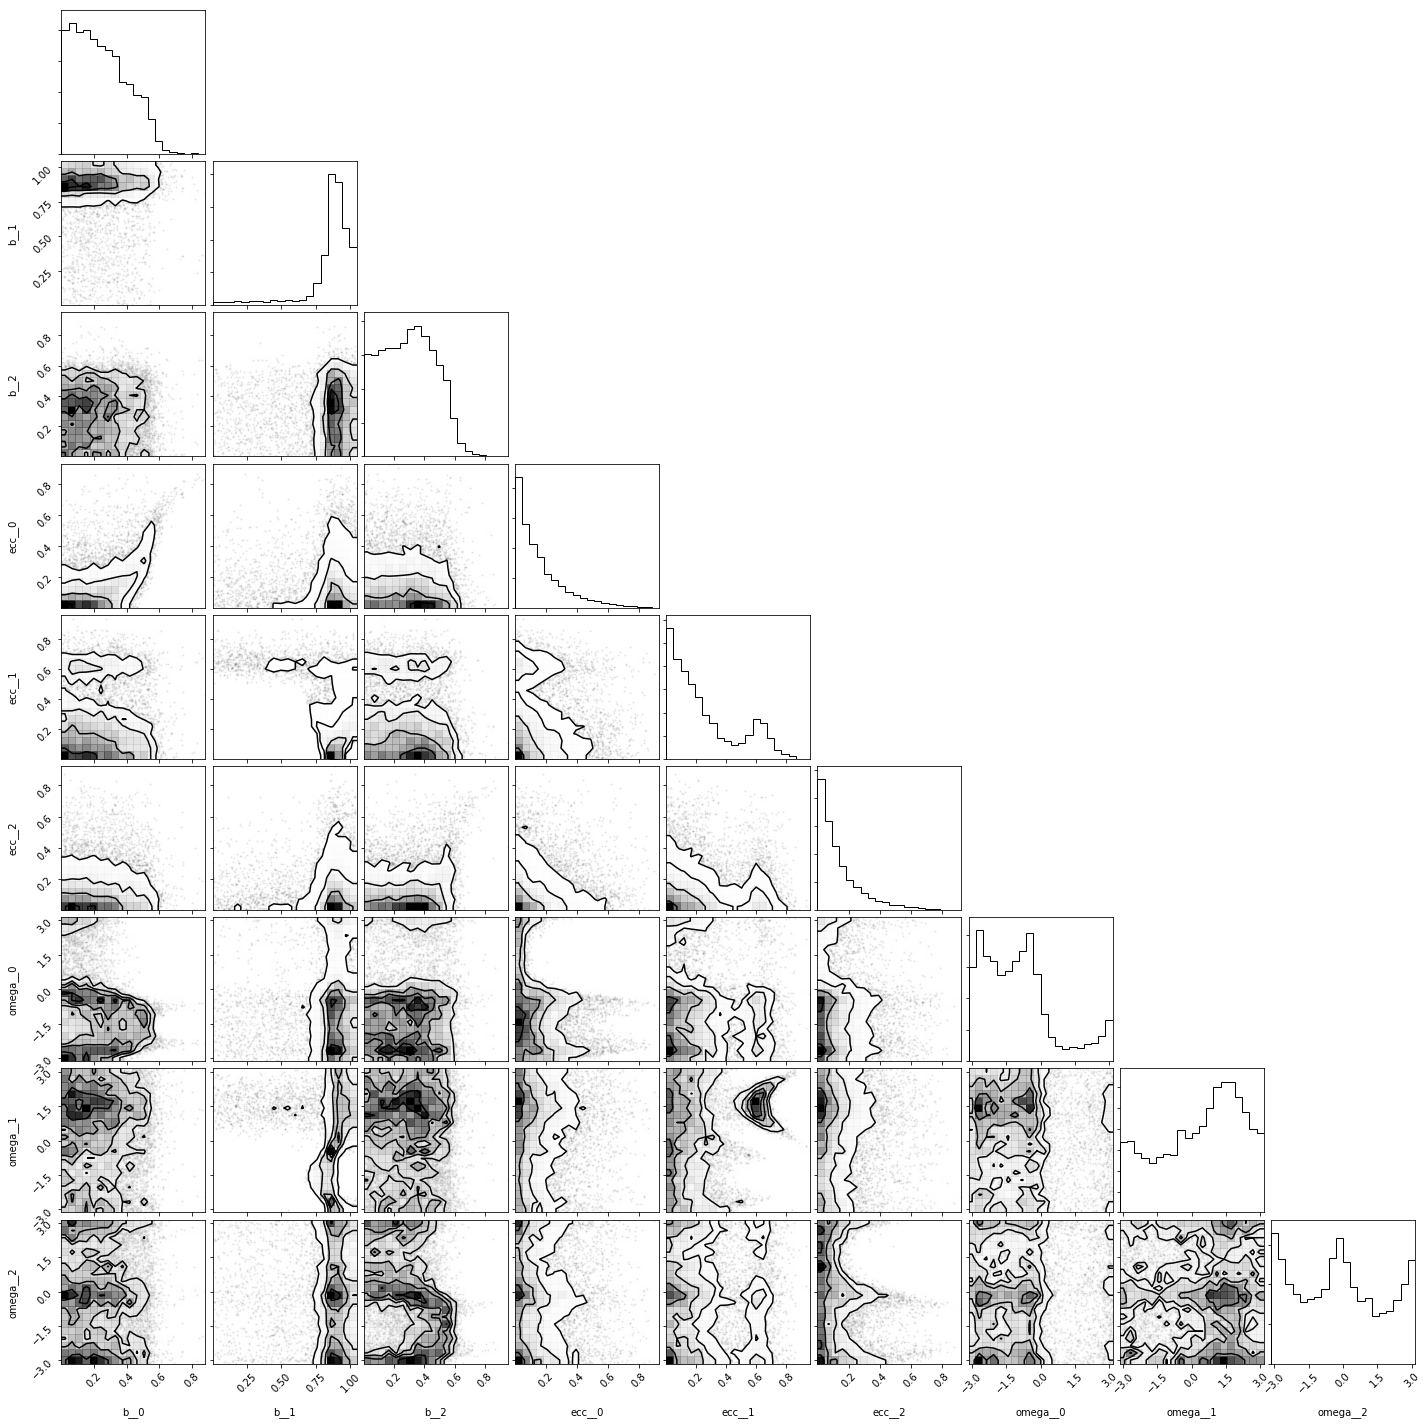

In [60]:
samples = pm.trace_to_dataframe(trace, varnames=["b", "ecc", "omega"])
corner.corner(samples);

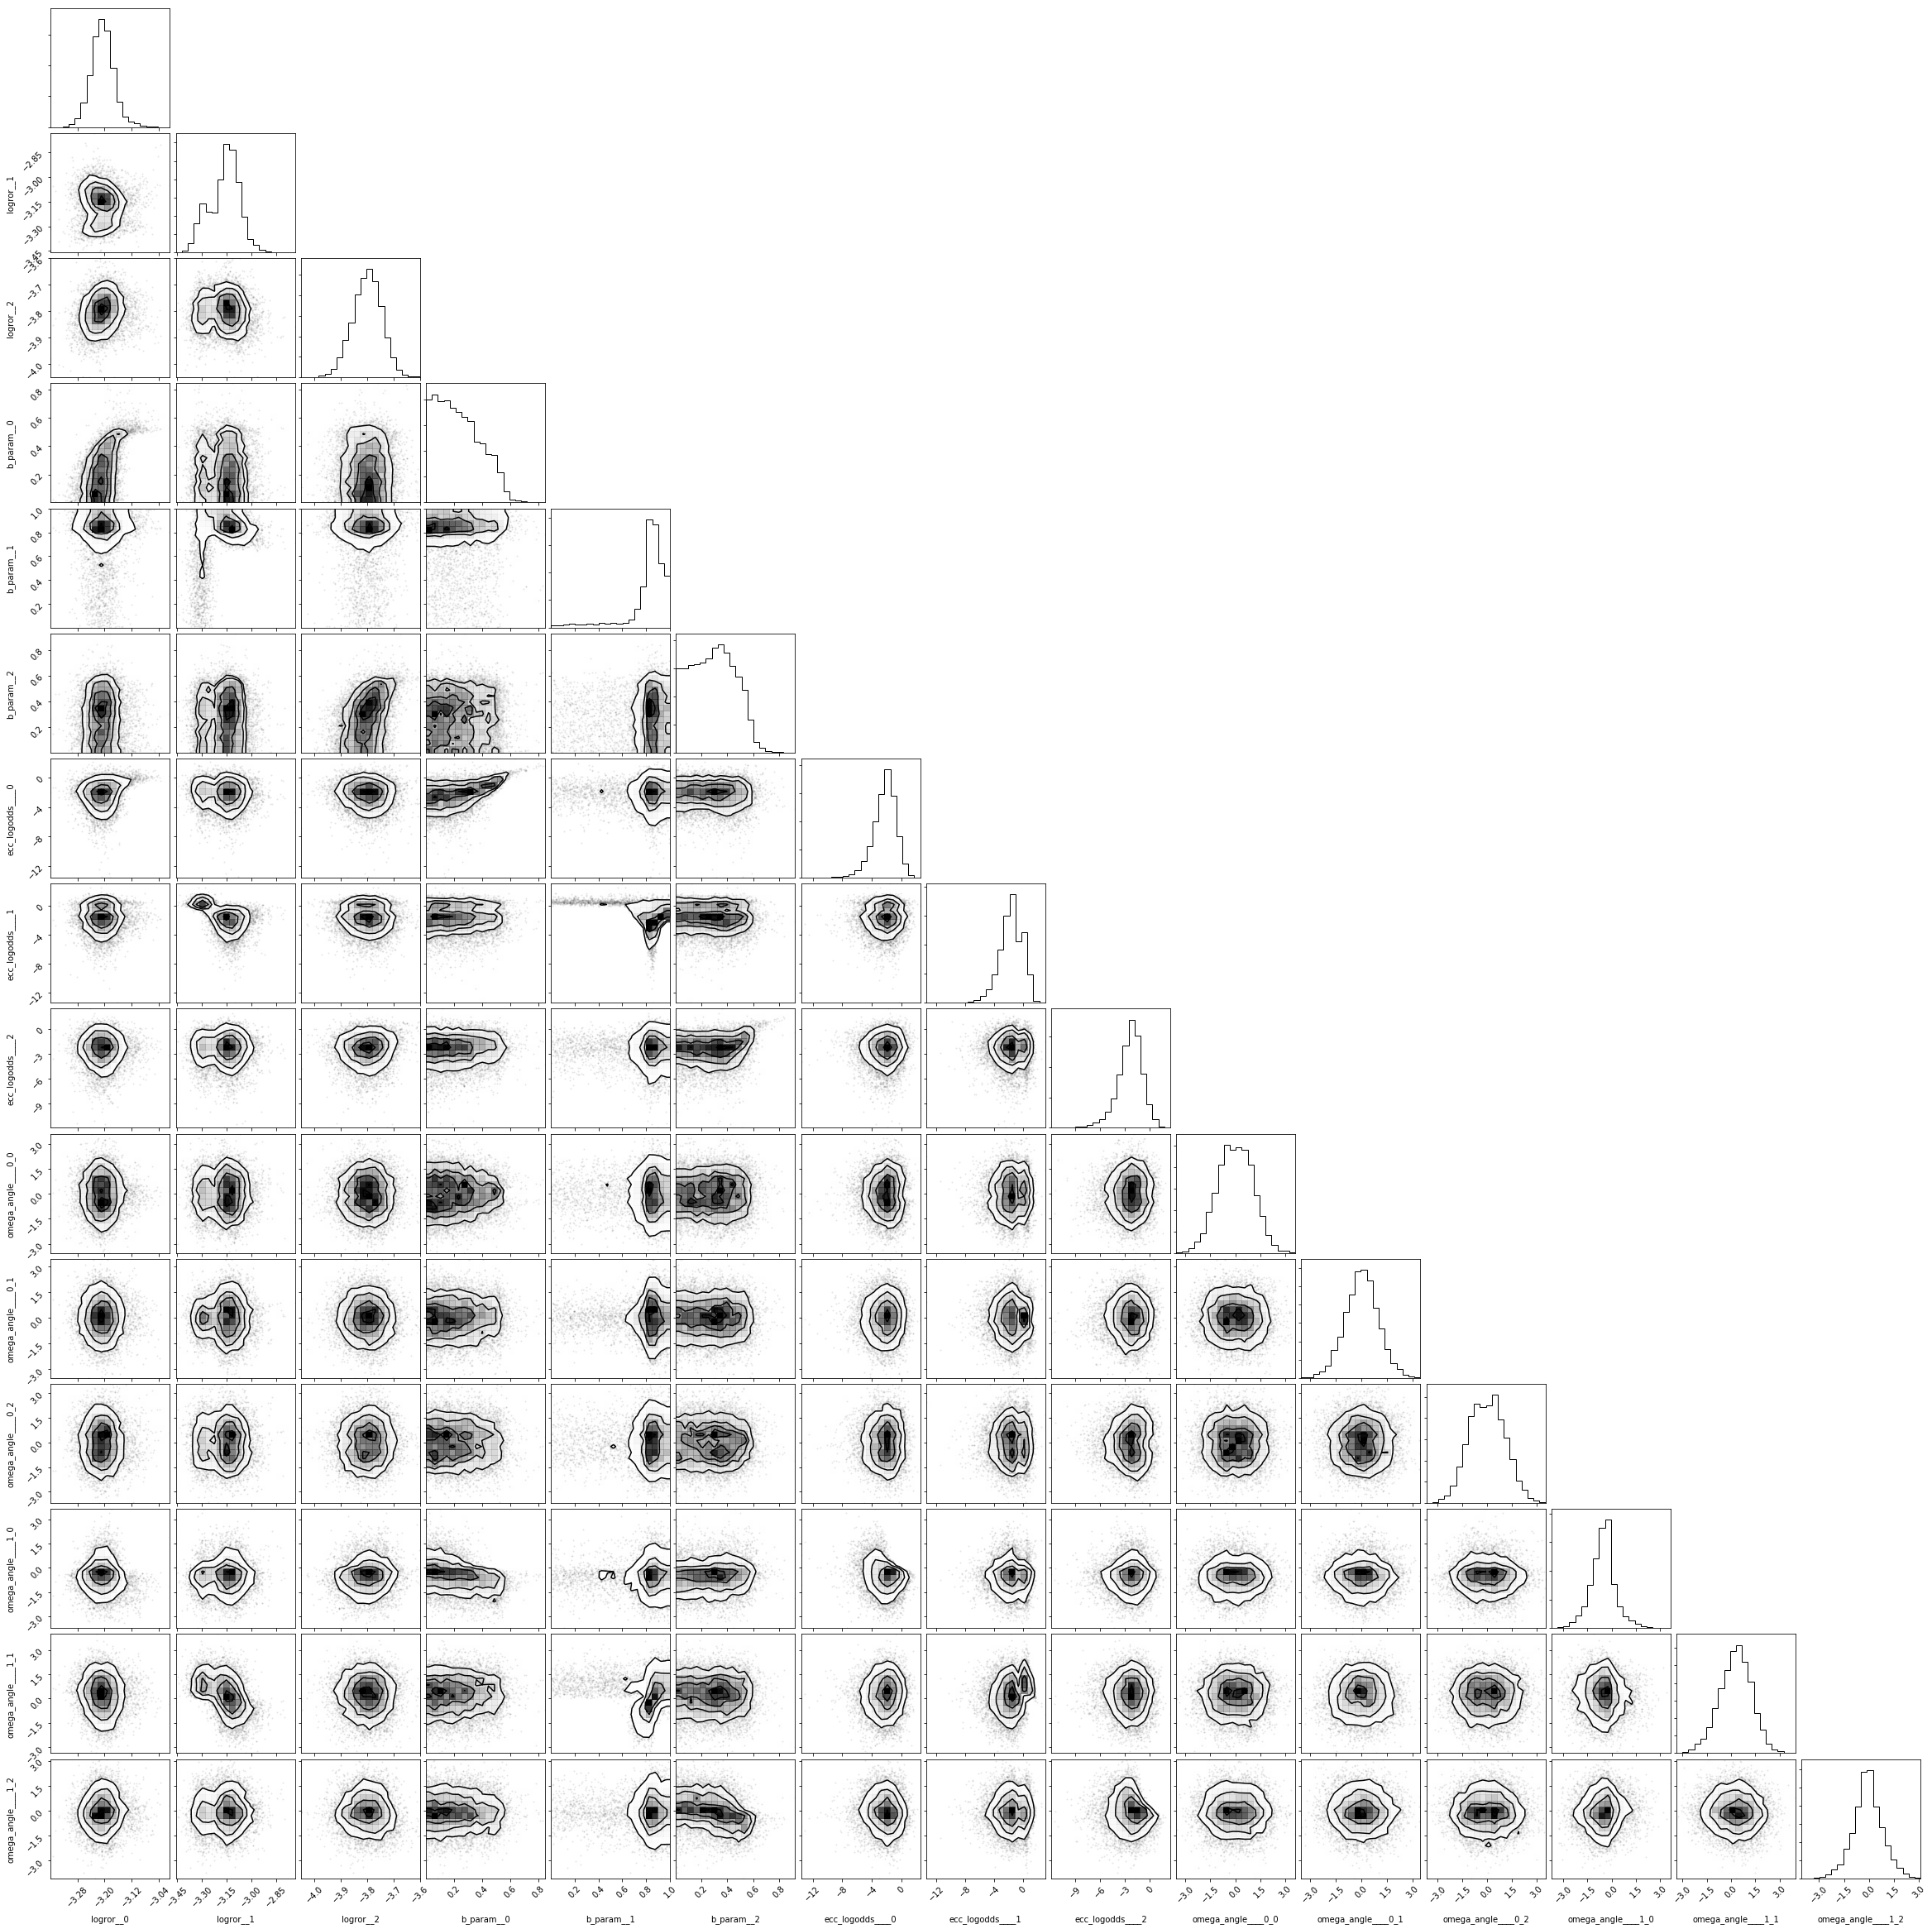

In [63]:
samples = pm.trace_to_dataframe(trace, varnames=["logror", "b_param", "ecc_logodds__", "omega_angle__"])
corner.corner(samples);